# Housekeep human preferences dataset

In this notebook, we provide a walk through our Housekeep human preferences dataset. 

Download the dataset [here](https://drive.google.com/drive/folders/1pnFWwEAtSupY0MCmvfYYaf6-kD9c0dp8) and upload it before running this notebook.

## Import packages and compile helper functions

In [2]:
import numpy as np
import pandas as pd

In [10]:
def receptacle_labels2vec(x):
  result = np.zeros((128,)) # because of 128 receptacles
  for recep in x:
     result[recep] = 1
  return result


def distance_metric(x, y):

  if np.all(x==y): # exactly same
    return 0

  dot_prod = np.dot(x, y)

  if (sum(x**2) + sum(y**2) - dot_prod) == 0:
    print(sum(x), sum(y))
    input('wait')

  # jaccard distance = 1 - jaccard similarity = 1 - (a n b)/(a U b)
  return 1 - dot_prod/(sum(x**2) + sum(y**2) - dot_prod)

## Load dataset

Our data is organized as a pandas DataFrame with following fields:



**annotator_idx**: The participants are indexed as 0, 1, ..., 370. 

**assignment_idx**: The assignments are indexed as 0, 1, ... . Each assignment has a set of 10 tasks which are solved by a single participant. Each individual task involves finding and ranking *correct* and *misplaced* receptacles in a given room for a given object. 

We collect 10 annotations for each object-room pair.

**object_idx**: object indexed as 0, 1, ..., 267.  

**room_idx**: room indexed as 0, 1, ..., 16.

**correct**/**misplaced**: ranked list of *correct*/*misplaced* room-receptacles. Each room-receptacle is indexed as 0, 1, ..., 127.

**implausible**: list of implausible room-receptacles indexed as 0, 1, ..., 127.


In [3]:
data_path = './housekeep.npy'
data_dict = np.load(data_path, allow_pickle=True).item()

In [6]:
objects = data_dict['objects']
object2index = dict({v:k for k, v in enumerate(objects)})
rooms = data_dict['rooms']
room_receps = data_dict['room_receptacles']
rooms2index = dict({v:k for k, v in enumerate(rooms)})
housekeep_data = data_dict['data']

## Visualizing the data

In [ ]:
print(f"Objects ({len(objects)}): {', '.join(objects[:5])}, ...")
print(f"Rooms ({len(rooms)}): {', '.join(rooms[:5])}, ...")
print(f"Room receptacles ({len(room_receps)}): {', '.join(room_receps[:5])}, ...")

# for o in objects: print(o)
for r in rooms: print(r)

In [ ]:
desired_rooms = ['bathroom', 'bedroom', 'dining_room', 'kitchen', 'living_room']
set_of_recepts = set()

for item in room_receps:
    room, recep = item.split('|')
    if room in desired_rooms: print(room, recep)
    set_of_recepts.update([recep])

# set_of_recepts

In [ ]:
print('All rooms: ', list(rooms))

for item in room_receps:
    room, recep = item.split('|')
    if recep == 'fridge':
        print(f'{room}-{recep}')

In [ ]:
print(f"Total number of rows: {len(housekeep_data)} (10 x n_objects x n_rooms)")
housekeep_data.head(5)

In [7]:
# Let's look at a sample annotation
id = 1

row = housekeep_data.loc[id]

object_name = objects[row['object_idx']]
room_name = rooms[row['room_idx']]
correct_receps = [room_receps[r].split('|')[1] for r in row['correct']]
misplaced_receps = [room_receps[r].split('|')[1] for r in row['misplaced']]
implausible_receps = [room_receps[r].split('|')[1] for r in row['implausible']]

print(f'Object: {object_name}, Room: {room_name}')
print(f"Correct (ranked): {', '.join(correct_receps)}")
print(f"Incorrect (ranked): {', '.join(misplaced_receps)}")
print(f"Implausible:  {', '.join(implausible_receps)}")

Object: lego_duplo, Room: utility_room
Correct (ranked): top_cabinet, bottom_cabinet
Incorrect (ranked): carpet, sink, washer, dryer
Implausible:  table


## do room names and room-receptacle names share the same room name? 

In [17]:
for id in range(len(housekeep_data)):
    row = housekeep_data.loc[id]

    room_name = rooms[row['room_idx']]
    correct_receps = [room_receps[r].split('|')[0] for r in row['correct']]
    if any([room_name != i for i in correct_receps]):
        print(room_name)
        print([x.split('|')[0] for x in correct_receps])
        print('---')

## Visualize generated clusters (from pkl)

In [8]:
import pickle as pkl
import matplotlib.pyplot as plt

# print(housekeep_data[(housekeep_data['object_idx']==object2index['cloth'])&(housekeep_data['room_idx']==rooms2index['kitchen'])])
# print(clustering_pandas_df[(clustering_pandas_df['object']=='cloth')&(clustering_pandas_df['room']=='kitchen')])

with open('all_clusters_poslessthan1en2.pkl', 'rb') as fh:
    cluster_objects_dict = pkl.load(fh)

object = 'lantern'
room = 'bathroom'

key = f'{object}_{room}'

if key not in cluster_objects_dict:
    print(f'cant find {key}')

clusters = cluster_objects_dict[key]

for c in clusters:
    print(c)
    print([room_receps[k] for k in c])
    print('---')

[0, 1, 3, 4, 5, 6, 7, 8]
['bathroom|bathtub', 'bathroom|bottom_cabinet', 'bathroom|counter', 'bathroom|shelf', 'bathroom|sink', 'bathroom|table', 'bathroom|toilet', 'bathroom|top_cabinet']
---
[0, 1, 3, 5, 7]
['bathroom|bathtub', 'bathroom|bottom_cabinet', 'bathroom|counter', 'bathroom|sink', 'bathroom|toilet']
---


## Calculate annotater agreement scores (Fleiss' Kappa)

In [5]:
def fleiss_kappa_kartik(subject_label_mat):

    assert isinstance(subject_label_mat, np.ndarray)

    rowwise_sum = np.sum(subject_label_mat, axis=1)
    nonzero_rows = np.where(rowwise_sum > 0)[0]

    # print('non0 rows: ', nonzero_rows) #DEBUG

    working_matrix = subject_label_mat[nonzero_rows, :]
    rowwise_sum_working = np.sum(working_matrix, axis=1) # number of ratings per subject

    # proportion of assignments belonging to jth category/column
    p_j_array = np.sum(working_matrix, axis=0)/np.sum(working_matrix)
    assert len(p_j_array) == working_matrix.shape[1]

    if any(p_j_array==1.0): # if all annotators chose either only correct or only the other
        return 1.0

    # agreement score for category i w.r.t. total number of annotator pairs
    P_i_array = (np.sum(working_matrix**2, axis=1) - rowwise_sum_working)/(rowwise_sum_working**2 - rowwise_sum_working)
    assert len(P_i_array) == working_matrix.shape[0]

    P_i_mean = np.mean(P_i_array)

    P_e_sum = np.sum(p_j_array**2)

    # print(working_matrix)
    # print(P_i_mean, P_e_sum)
    # input('wait')

    return 1.0*(P_i_mean-P_e_sum)/(1-P_e_sum)

### Agreement combining misplaced and incorrect

In [6]:
object_agreement_scores_combined = dict({})

for object_idx in range(268):
    for room_idx in range(17):
        filtered_values = np.where((housekeep_data['object_idx']==object_idx)&(housekeep_data['room_idx']==room_idx))

        receptacle2labels = np.zeros((128, 2)) # receptacle2labels[rcpt] = correct/incorrect(misplaced, implausible)

        for i, d in housekeep_data.loc[filtered_values].iterrows():
            for rcpt in d['correct']:
                receptacle2labels[rcpt, 0] += 1

            for rcpt in d['misplaced']:
                receptacle2labels[rcpt, 1] += 1

            for rcpt in d['implausible']:
                receptacle2labels[rcpt, 1] += 1

        object_agreement_scores_combined['{}/{}'.format(objects[object_idx], rooms[room_idx])] = fleiss_kappa_kartik(receptacle2labels)

2056


(-0.2, 1.2)

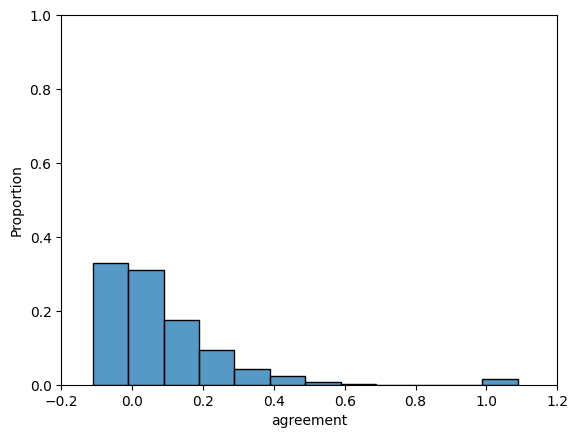

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

keys = object_agreement_scores_combined.keys()
object_agreement_scores_combined_pd = pd.DataFrame({
    'label': keys, 'agreement': [object_agreement_scores_combined[k] for k in keys]
})

print(len(object_agreement_scores_combined_pd[(0.0<object_agreement_scores_combined_pd['agreement'])&(object_agreement_scores_combined_pd['agreement']<=0.2)]))

sns.histplot(data=object_agreement_scores_combined_pd, x='agreement', binwidth=0.1, stat='proportion')
plt.ylim(0, 1.0)
plt.xlim(-0.2, 1.2)

### Save examples with agreement between 0 and 0.2

In [10]:
# save all objects with agreement scores less than 0.2
with open('housekeep_poslessthan1en2_agreement.txt', 'w') as fw:
    for k, v in object_agreement_scores_combined.items():
        if 0 < v <= 0.2:
            fw.write(f'{k},{v}\n')

### Agreement separating correct, misplaced and incorrect

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa as fleiss_kappa_stats
object_agreement_scores = dict({})

for object_idx in range(268):
    for room_idx in range(17):
        filtered_values = np.where((housekeep_data['object_idx']==object_idx)&(housekeep_data['room_idx']==room_idx))

        receptacle2labels = np.zeros((128, 3)) # receptacle2labels[rcpt] = correct/misplaced/implausible

        for i, d in housekeep_data.loc[filtered_values].iterrows():
            for rcpt in d['correct']:
                receptacle2labels[rcpt, 0] += 1

            for rcpt in d['misplaced']:
                receptacle2labels[rcpt, 1] += 1

            for rcpt in d['implausible']:
                receptacle2labels[rcpt, 2] += 1

        # ---- Using my function ---- 
        object_agreement_scores['{}/{}'.format(objects[object_idx], rooms[room_idx])] = fleiss_kappa_kartik(receptacle2labels)

        # # --- Using statsmodel func ---

        # rowwise_sum = np.sum(receptacle2labels, axis=1) # remove empty rows
        # nonzero_rows = np.where(rowwise_sum > 0)[0]
        # working_matrix = receptacle2labels[nonzero_rows, :]

        # if not all(np.sum(working_matrix, axis=1) == 10): # remove examples with unequal number of annotators
        #     print('skip... ', np.sum(working_matrix, axis=1))
        #     continue
        # object_agreement_scores['{}/{}'.format(objects[object_idx], rooms[room_idx])] = fleiss_kappa_stats(table=working_matrix, method='fleiss')

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

keys = object_agreement_scores.keys()
object_agreement_scores_pd = pd.DataFrame({
    'label': keys, 'agreement': [object_agreement_scores[k] for k in keys]
})

print(len(object_agreement_scores_pd[object_agreement_scores_pd['agreement']<=0.0]))

sns.histplot(data=object_agreement_scores_pd, x='agreement', binwidth=0.1, stat='proportion')
plt.ylim(0, 1.0)
plt.xlim(-0.2, 1.2)

#### Save object-room pairs with agreement \<= 0.0

In [ ]:
# save all objects with agreement scores less than 0.2
with open('housekeep_worst_agreement.txt', 'w') as fw:
    for k, v in object_agreement_scores.items():
        if v <= 0:
            fw.write(f'{k},{v}\n')

## Misc: Clustering object-receptacle pairs based on distance threshold

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import seaborn as sns

THRESHOLD = 0.3

clustering_pandas_df = pd.DataFrame([], 
    columns=['objectid', 'roomid', 'num_clusters', 'cluster_asgns'])

for object_idx in range(268):

  filtered_values = np.where(housekeep_data['object_idx'] == object_idx)
  annotators = []
  datapoints = []

  # lists to vector
  for i, d in housekeep_data.loc[filtered_values].iterrows():

    vec = np.concatenate([receptacle_labels2vec(d['correct']), 
                            receptacle_labels2vec(d['misplaced']),
                            receptacle_labels2vec(d['implausible'])])

    annotators.append(d['annotator_idx'])
    datapoints.append(vec[np.newaxis, :])

  # array of datapoints
  datapoints_array = np.concatenate(datapoints, axis=0)

  # pairwise distance matrix
  pairwise_dist_mat = np.zeros((len(datapoints_array), len(datapoints_array)))
  for i1, d1 in enumerate(datapoints_array):
    for i2, d2 in enumerate(datapoints_array):
      pairwise_dist_mat[i1, i2] = distance_metric(d1, d2)

  # clusters
  clusters = AgglomerativeClustering(n_clusters=None, affinity="precomputed", linkage="single", distance_threshold=THRESHOLD).fit_predict(pairwise_dist_mat)
  num_clusters = 1 + max(clusters)

  clustering_pandas_df = pd.concat([clustering_pandas_df, pd.DataFrame(dict({'objectid':[object_idx],
                                                                              'num_clusters': [num_clusters],
                                                                              'cluster_asgns': (len(clusters)*'{}-').format(*clusters)
                                                                                }))
                                    ], ignore_index=True)

In [ ]:
if THRESHOLD == 0.5:
    clustering_pandas_df.to_csv('./dataframe_distthresh-5en1.csv', encoding = 'utf-8-sig')
elif THRESHOLD == 0.7:
    clustering_pandas_df.to_csv('./dataframe_distthresh-7en1.csv', encoding = 'utf-8-sig')
elif THRESHOLD == 0.3:
    clustering_pandas_df.to_csv('./dataframe_distthresh-3en1.csv', encoding = 'utf-8-sig')

In [ ]:
import matplotlib.pyplot as plt

THRESHOLD = 0.3
if THRESHOLD == 0.5:
    clustering_pandas_df = pd.read_csv('./dataframe_distthresh-5en1.csv')
elif THRESHOLD == 0.7:
    clustering_pandas_df = pd.read_csv('./dataframe_distthresh-7en1.csv')
elif THRESHOLD == 0.3:
    clustering_pandas_df = pd.read_csv('./dataframe_distthresh-3en1.csv')

tuples_to_plot = pd.DataFrame([], columns=['obj_room', 'num_clusters'])
for _, row in clustering_pandas_df.iterrows():
  newdf = pd.DataFrame(
      dict({'obj_room':['o{}r{}'.format(row['objectid'], row['roomid'])],
            'num_clusters': [row['num_clusters']]
            })
      )
  tuples_to_plot = pd.concat([tuples_to_plot, newdf], ignore_index=True)

plt.figure(figsize=(12, 8))
sns.histplot(data=tuples_to_plot, x='num_clusters', discrete=True)
plt.xticks(range(11))
tuples_to_plot.head()


# Debug

In [28]:
import pickle as pkl

# load clusters of correct receptacle labels
with open('all_clusters_poslessthan1en2_maxclusters3.pkl', 'rb') as fh:
    cluster_objects_dict = pkl.load(fh)

for key, value in cluster_objects_dict.items():
    roomname_key = key.split('+')[1]

    for v in value:
        
        roomnames_v_list = [room_receps[i].split('|')[0] for i in v]

        if not all([roomname_key == i for i in roomnames_v_list]):
            print(key)
            print(v, roomnames_v_list)
            print('---')

In [ ]:
# load persona data
with open('housekeep_personas_poslessthan1en2_maxclusters3.pkl', 'rb') as fh:
    persona_data_dict = pkl.load(fh)

for value in persona_data_dict.values():
    persona = value['persona']

    for sk, usk, skr, uskr in zip(value['seen_keys'], value['unseen_keys'], value['seen_key_recepts'], value['unseen_key_recepts']):
        sk_room = sk.split('+')[1]
        usk_room = usk.split('+')[1]

        skr_rooms = [room_receps[i].split('|')[0] for i in skr]
        uskr_rooms = [room_receps[i].split('|')[0] for i in uskr]

        if any([sk_room ])